In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from torch.utils.data import Dataset
import os
from torchvision.io import read_image
from torch.utils.data import DataLoader
import torch.optim as optim

In [3]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


In [4]:
kid = pd.read_csv('/content/kid.csv')

In [5]:
train_df, test_df = train_test_split(kid, test_size=0.1, random_state=42)

In [6]:
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

In [7]:
kid.iloc[:,0]

0       0
1       1
2       2
3       3
4       4
       ..
8164    4
8165    5
8166    6
8167    7
8168    8
Name: label, Length: 8169, dtype: int64

In [8]:
class KannadaImageDataset(Dataset):
    def __init__(self, image_df):
        self.img_labels = image_df.iloc[:,0].values
        self.img_df = image_df.iloc[:,1:].values

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        image = torch.tensor(self.img_df[idx]).reshape(1,28,28)
        label = self.img_labels[idx]

        return image, label

In [9]:
train_dataset = KannadaImageDataset(train_df)
test_dataset = KannadaImageDataset(test_df)
val_dataset = KannadaImageDataset(val_df)

In [10]:
'''train_dataset
<__main__.KannadaImageDataset at 0x7e00494736a0>
test_dataset
<__main__.KannadaImageDataset at 0x7e011f19d4e0>
val_dataset
<__main__.KannadaImageDataset at 0x7e011f19d120>'''

'train_dataset\n<__main__.KannadaImageDataset at 0x7e00494736a0>\ntest_dataset\n<__main__.KannadaImageDataset at 0x7e011f19d4e0>\nval_dataset\n<__main__.KannadaImageDataset at 0x7e011f19d120>'

In [11]:
next(iter(train_dataset))[0].shape

torch.Size([1, 28, 28])

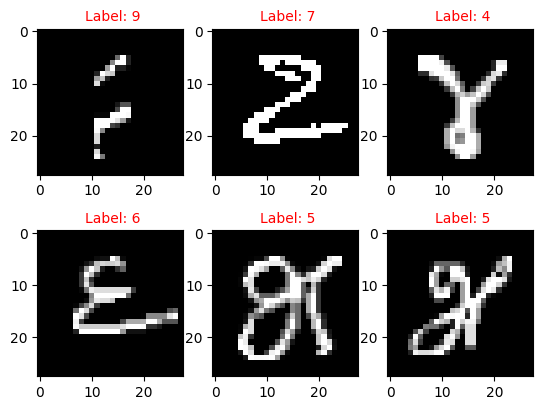

In [12]:
for i in range(6):
    label = val_df.iloc[:,0].values[i]
    image = torch.tensor(val_df.drop(val_df.iloc[:,0].name, axis=1).iloc[i,:].values).reshape(28,28,1)
    plt.subplot(2,3,i+1)
    plt.imshow(image, cmap='gray')
    plt.text(14, -2, f"Label: {label}", ha='center', fontsize=10, color='red')
plt.show()

In [13]:
train_loader = DataLoader(dataset=train_dataset,batch_size=64,shuffle=True)
val_loader = DataLoader(dataset=val_dataset,batch_size=64,shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64,shuffle=False)

In [14]:
next(iter(train_loader))[0].shape

torch.Size([64, 1, 28, 28])

In [15]:
class KannadaMNIST(nn.Module):
    def __init__(self):
        super(KannadaMNIST, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, 5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(7 * 7 * 64, 1024),
            nn.Dropout(0.5),
            nn.Linear(1024, 10))

        # Cast model parameters to Double
        for layer in self.children():
            for param in layer.parameters():
                param.data = param.data.double()

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        return self.fc1(x)

In [16]:
model = KannadaMNIST()
model.to(device)
print(model)

KannadaMNIST(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=1024, bias=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=1024, out_features=10, bias=True)
  )
)


In [17]:
train_losses=[]
val_losses=[]

In [18]:
learning_rate=1e-4
num_epochs=10
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn=nn.CrossEntropyLoss()

In [20]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        inputs, labels = batch
        inputs, labels = inputs.to(device).double(), labels.to(device).long()  # Cast inputs to Double and labels to Long

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = loss_fn(outputs, labels)

        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        total = 0
        correct = 0
        for batch in val_loader:
            inputs, labels = batch
            inputs, labels = inputs.to(device).double(), labels.to(device).long()  # Cast inputs to Double and labels to Long

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}, Validation Accuracy: {accuracy:.2f}%')

Epoch 1/10, Loss: 0.0119, Validation Accuracy: 96.06%
Epoch 2/10, Loss: 0.0091, Validation Accuracy: 95.24%
Epoch 3/10, Loss: 0.0861, Validation Accuracy: 95.92%
Epoch 4/10, Loss: 0.0035, Validation Accuracy: 95.65%
Epoch 5/10, Loss: 0.0093, Validation Accuracy: 96.06%
Epoch 6/10, Loss: 0.0012, Validation Accuracy: 95.79%
Epoch 7/10, Loss: 0.0026, Validation Accuracy: 95.65%
Epoch 8/10, Loss: 0.0095, Validation Accuracy: 96.06%
Epoch 9/10, Loss: 0.0051, Validation Accuracy: 96.06%
Epoch 10/10, Loss: 0.0001, Validation Accuracy: 96.06%
